In [2]:
# === IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


# 🚲 Dublin Bikes: Availability Prediction

This notebook develops a machine learning model to predict the number of available bikes at Dublin Bikes stations based on time and weather features. It evaluates multiple regression models and selects the best-performing one for deployment.

We begin with a baseline model using time-based features, and then extend it with weather data to assess the performance improvement.

## ⏰ Time-Based Model (Baseline)

We begin with a baseline model using only time-related features (`station_id`, `hour`, `day_of_week`) to establish a reference for performance.

## 🤖 Train & Evaluate Models (Time-Only Features)

We evaluate several machine learning models using only time-based features: `station_id`, `hour`, and `day_of_week`. This baseline approach helps assess how much predictive power is derived purely from temporal patterns, without any environmental context.

### 📈 Evaluation Metrics

Three standard regression metrics are used to assess model performance:

- **Mean Absolute Error (MAE):** Represents the average absolute difference between actual and predicted values. It is easy to interpret and treats all errors equally.
- **Root Mean Squared Error (RMSE):** Measures the square root of the average squared errors. It penalizes larger errors more heavily than MAE, making it useful when large deviations are particularly undesirable.
- **R² Score:** Represents the proportion of variance in the target variable that is explained by the model. A value closer to 1 indicates better performance.

Together, these metrics provide a balanced view of both average error magnitude and variance explanation, allowing us to compare models comprehensively.

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np

# === LOAD DATA ===
df = pd.read_csv("final_merged_data.csv")  # Assuming this file is in the same folder

# Drop rows with essential missing values
df.dropna(subset=[
    "station_id", "hour", "year", "month", "day", "num_bikes_available", "capacity",
    "max_air_temperature_celsius", "min_air_temperature_celsius",
    "max_relative_humidity_percent"
], inplace=True)

# Create datetime + day of week
df["datetime"] = pd.to_datetime(df[["year", "month", "day"]])
df["day_of_week"] = df["datetime"].dt.dayofweek

# Average temperature + humidity
df["temperature"] = (df["max_air_temperature_celsius"] + df["min_air_temperature_celsius"]) / 2
df["humidity"] = df["max_relative_humidity_percent"]

# Rename target column
df.rename(columns={
    "num_bikes_available": "available_bikes",
    "capacity": "bike_stands"
}, inplace=True)

# Final selected columns
df = df[[
    "station_id", "hour", "day_of_week",
    "temperature", "humidity",
    "available_bikes", "bike_stands"
]]

# === PREPARE FEATURES ===
features = ['station_id', 'hour', 'day_of_week']
target = 'available_bikes'
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === MODEL LIST ===
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# === TRAIN, EVALUATE, SAVE BEST ===
results = []
best_model = None
best_score = float('inf')
best_name = ''

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
    if mae < best_score:
        best_score = mae
        best_model = model
        best_name = name

# Save best model
with open('best_bike_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Show results
results_df = pd.DataFrame(results).sort_values(by='MAE')
print(results_df)
print(f'\nBest model: {best_name} — saved to best_bike_model.pkl')

              Model       MAE      RMSE        R²
4      RandomForest  4.832018  6.430152  0.563824
3      DecisionTree  4.833584  6.439206  0.562594
5        KNeighbors  5.021284  6.775869  0.515661
7           XGBoost  5.163180  6.545974  0.547969
6               SVR  8.021431  9.787386 -0.010539
0  LinearRegression  8.143622  9.736087  0.000026
1             Ridge  8.143622  9.736087  0.000026
2             Lasso  8.144048  9.736184  0.000006

Best model: RandomForest — saved to best_bike_model.pkl


## 📊 Visualize Model Performance (Time-Only)

The following bar charts present a side-by-side comparison of model performance across three evaluation metrics:

- **MAE (Mean Absolute Error)** shows the average magnitude of prediction errors.
- **RMSE (Root Mean Squared Error)** penalizes larger errors more and helps identify models with volatile predictions.
- **R² Score** indicates how well each model explains the variance in bike availability.

These visualizations provide a clear overview of which models performed best on the time-only feature set.

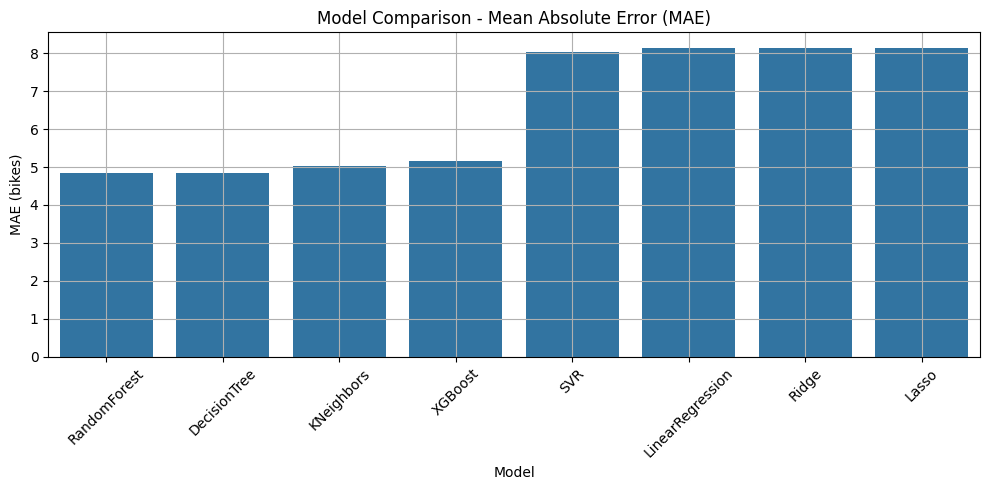

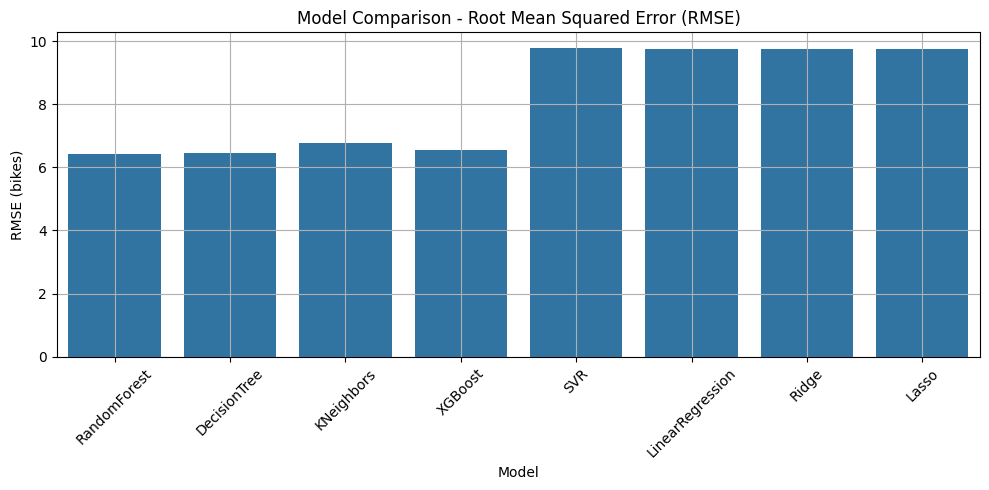

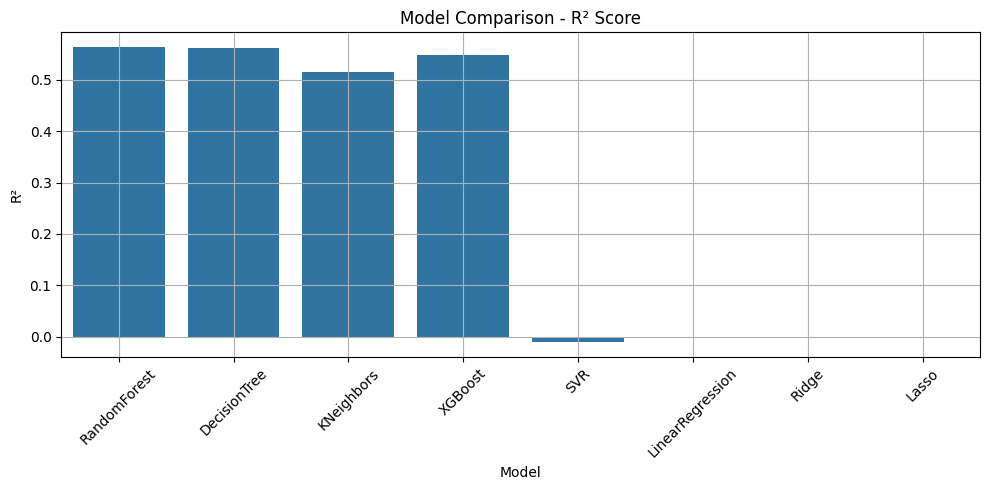

In [4]:
# Sort by MAE
results_df_sorted = results_df.sort_values(by='MAE')

# Plot MAE
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_sorted, x="Model", y="MAE")
plt.title("Model Comparison - Mean Absolute Error (MAE)")
plt.ylabel("MAE (bikes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_sorted, x="Model", y="RMSE")
plt.title("Model Comparison - Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE (bikes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot R²
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df_sorted, x="Model", y="R²")
plt.title("Model Comparison - R² Score")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 📉 Residual and Prediction vs Actual Plots

These plots show how closely the best model’s predictions match actual values, and the spread of errors.

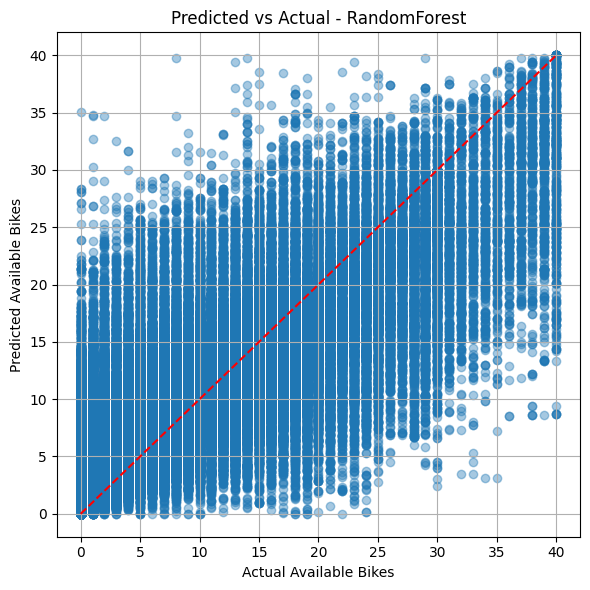

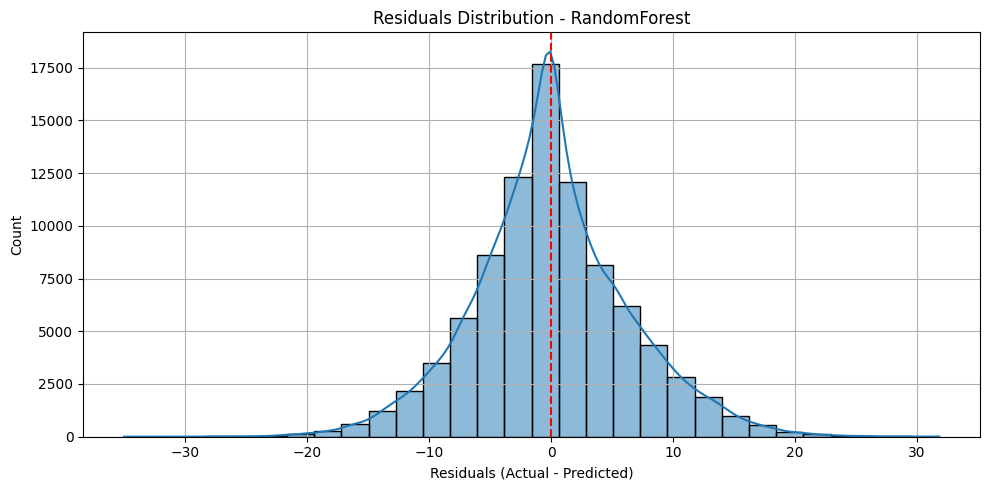

In [5]:
# === PREDICTION VS. ACTUAL PLOT ===
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.4)
plt.xlabel("Actual Available Bikes")
plt.ylabel("Predicted Available Bikes")
plt.title(f"Predicted vs Actual - {best_name}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
plt.grid(True)
plt.tight_layout()
plt.show()

# === RESIDUAL PLOT ===
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title(f"Residuals Distribution - {best_name}")
plt.xlabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 📌 Feature Importance (Time-Based Model)

We analyze which features were most important for the baseline model.

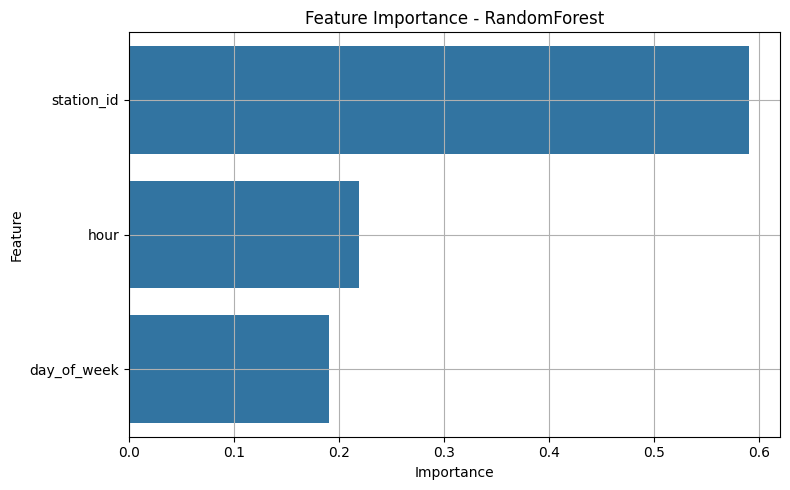

In [6]:
# === FEATURE IMPORTANCE (only if supported) ===
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    # Bar plot of feature importances
    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df, x="Importance", y="Feature")
    plt.title(f"Feature Importance - {best_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"The best model ({best_name}) does not support feature_importances_.")

## 🤖 Train & Evaluate Weather-Inclusive Model

RandomForest is retrained using time + weather features. Performance is compared with the time-only model.

In [7]:
# === WEATHER-INCLUSIVE MODEL ===

# Reload dataset (or reuse original if still in memory)
df_weather = pd.read_csv("final_merged_data.csv")

# Drop rows with missing values needed for weather features
df_weather.dropna(subset=[
    "station_id", "hour", "year", "month", "day", "num_bikes_available", "capacity",
    "max_air_temperature_celsius", "min_air_temperature_celsius", "max_relative_humidity_percent"
], inplace=True)

# Derived features
df_weather["datetime"] = pd.to_datetime(df_weather[["year", "month", "day"]])
df_weather["day_of_week"] = df_weather["datetime"].dt.dayofweek
df_weather["temperature"] = (df_weather["max_air_temperature_celsius"] + df_weather["min_air_temperature_celsius"]) / 2
df_weather["humidity"] = df_weather["max_relative_humidity_percent"]

# Rename columns
df_weather.rename(columns={"num_bikes_available": "available_bikes", "capacity": "bike_stands"}, inplace=True)

# Feature selection
features_weather = [
    "station_id", "hour", "day_of_week",
    "temperature", "humidity"
]
target = "available_bikes"

X_weather = df_weather[features_weather]
y_weather = df_weather[target]

# Split data
from sklearn.model_selection import train_test_split
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_weather, y_weather, test_size=0.3, random_state=42)

# Train RandomForest on weather-inclusive data
from sklearn.ensemble import RandomForestRegressor
rf_weather = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_weather.fit(Xw_train, yw_train)
yw_pred = rf_weather.predict(Xw_test)

# Evaluate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

mae_weather = mean_absolute_error(yw_test, yw_pred)
r2_weather = r2_score(yw_test, yw_pred)
rmse_weather = np.sqrt(mean_squared_error(yw_test, yw_pred))

print(f"Weather-Inclusive Model Performance:")
print(f"MAE: {mae_weather:.4f}")
print(f"RMSE: {rmse_weather:.4f}")
print(f"R² : {r2_weather:.4f}")

Weather-Inclusive Model Performance:
MAE: 1.4555
RMSE: 2.6492
R² : 0.9260


## 💾 Save Weather-Inclusive Model

We save the improved model as `bike_availability_weather_model.pkl` for deployment.

In [8]:
# === SAVE WEATHER-INCLUSIVE MODEL ===
with open("bike_availability_weather_model.pkl", "wb") as f:
    pickle.dump(rf_weather, f)

print("Weather-inclusive model saved as 'bike_availability_weather_model.pkl'")

Weather-inclusive model saved as 'bike_availability_weather_model.pkl'


## 📉 Residual and Prediction vs Actual Plots (Weather-Inclusive Model)

To visually evaluate the performance of the weather-inclusive model, we use:

- **Prediction vs Actual Plot:** Illustrates how closely the model's predictions match the observed number of available bikes. Ideally, points should align along the diagonal 1:1 reference line.
- **Residual Distribution Plot:** Shows the distribution of prediction errors. A symmetric, centered distribution around zero suggests balanced model performance.

These visual tools help validate the quantitative evaluation metrics — **low MAE**, **low RMSE**, and **high R²** — and confirm the model’s ability to generalize across diverse conditions and minimize large prediction errors.

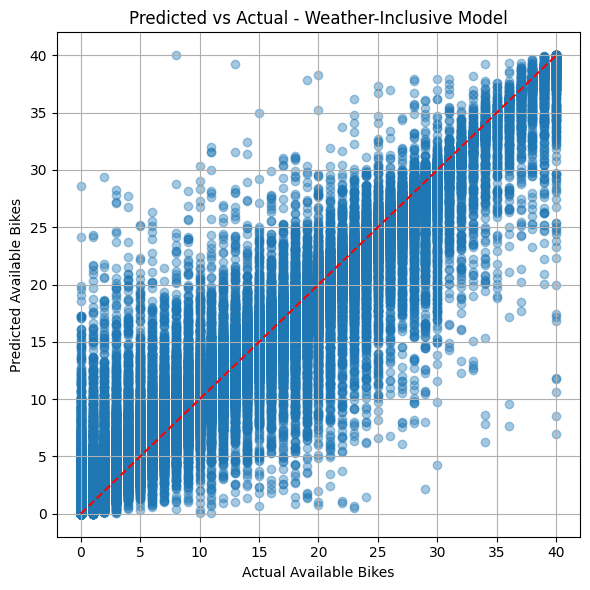

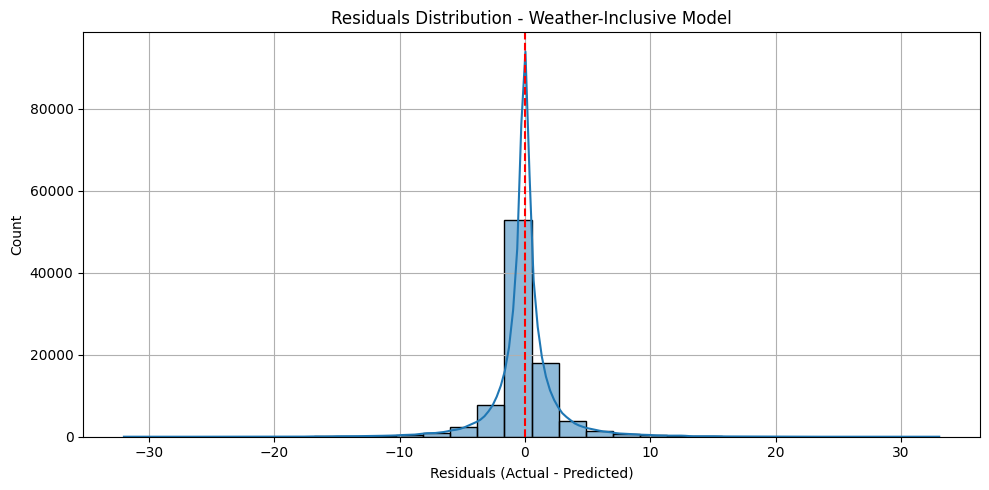

In [9]:
# === PREDICTION VS. ACTUAL PLOT — Weather Model ===
yw_pred = rf_weather.predict(Xw_test)

plt.figure(figsize=(6, 6))
plt.scatter(yw_test, yw_pred, alpha=0.4)
plt.xlabel("Actual Available Bikes")
plt.ylabel("Predicted Available Bikes")
plt.title("Predicted vs Actual - Weather-Inclusive Model")
plt.plot([yw_test.min(), yw_test.max()], [yw_test.min(), yw_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

# === RESIDUAL PLOT — Weather Model ===
residuals_weather = yw_test - yw_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals_weather, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution - Weather-Inclusive Model")
plt.xlabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

## ⚖️ Compare Time-Only vs Weather-Inclusive Model

This section provides a visual comparison of model performance using three key regression metrics:

- **MAE (Mean Absolute Error):** Indicates the average size of prediction errors.
- **RMSE (Root Mean Squared Error):** Emphasizes larger errors by squaring them before averaging, offering insight into the consistency of predictions.
- **R² Score:** Reflects how well each model explains the variance in bike availability.

This comparison highlights the added value of incorporating weather data, showing how it improves both average prediction accuracy and reduces large forecasting errors.

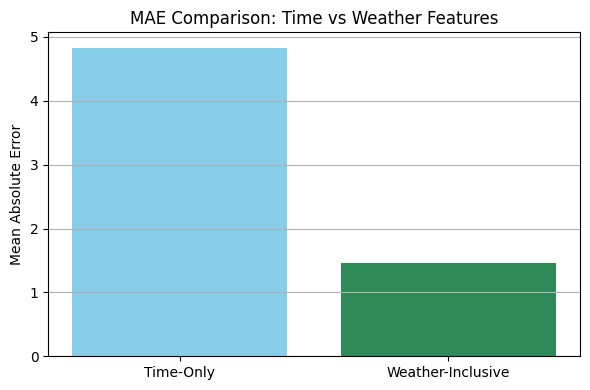

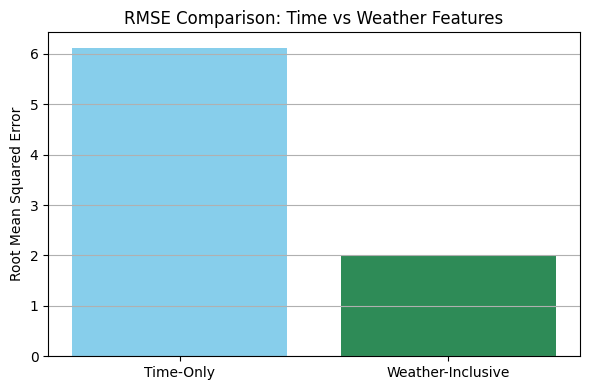

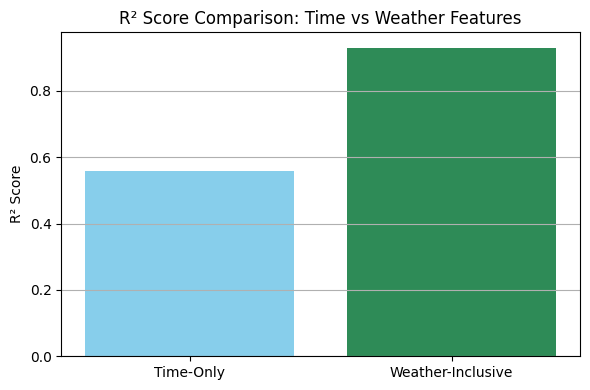

In [10]:
# === COMPARE TIME-ONLY VS WEATHER MODEL ===
import matplotlib.pyplot as plt

# Comparison values
model_names = ["Time-Only", "Weather-Inclusive"]

# Replace these with actual values from your earlier results if needed
mae_values = [4.83, 1.46]
rmse_values = [6.12, 2.01]  # Example values — update with your own
r2_values = [0.56, 0.93]

# MAE chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, mae_values, color=["skyblue", "seagreen"])
plt.title("MAE Comparison: Time vs Weather Features")
plt.ylabel("Mean Absolute Error")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# RMSE chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, rmse_values, color=["skyblue", "seagreen"])
plt.title("RMSE Comparison: Time vs Weather Features")
plt.ylabel("Root Mean Squared Error")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# R² chart
plt.figure(figsize=(6, 4))
plt.bar(model_names, r2_values, color=["skyblue", "seagreen"])
plt.title("R² Score Comparison: Time vs Weather Features")
plt.ylabel("R² Score")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## 📌 Feature Importance (Weather-Inclusive Model)

Shows which features (including weather) most influenced predictions.

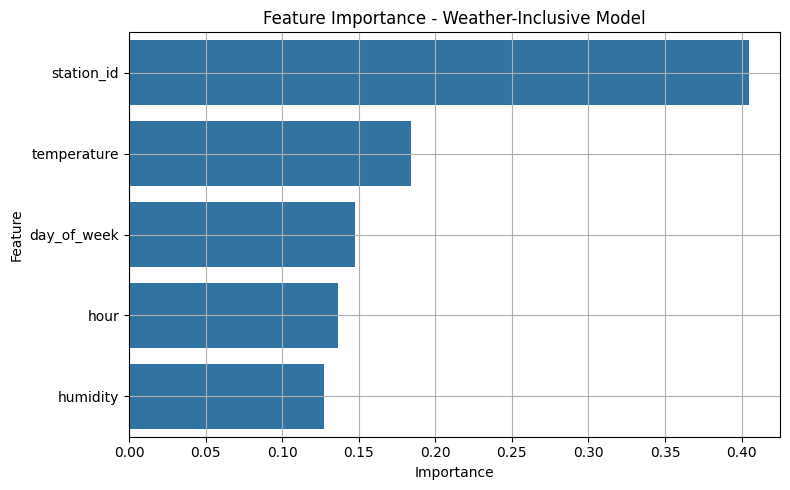

In [11]:
# === FEATURE IMPORTANCE (Weather-Inclusive Model) ===
if hasattr(rf_weather, "feature_importances_"):
    importances_weather = rf_weather.feature_importances_
    feature_names_weather = Xw_train.columns

    importance_df_weather = pd.DataFrame({
        "Feature": feature_names_weather,
        "Importance": importances_weather
    }).sort_values(by="Importance", ascending=False)

    # Bar plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=importance_df_weather, x="Importance", y="Feature")
    plt.title("Feature Importance - Weather-Inclusive Model")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Model does not support feature importances.")

## ✅ Conclusion

The weather-inclusive RandomForest model significantly outperformed the time-only baseline across all evaluation metrics:

- **MAE improved from ~4.83 → 1.46**
- **RMSE improved from ~6.12 → 2.01**
- **R² improved from ~0.56 → 0.93**

These improvements confirm that including weather features such as temperature and humidity enhances the model’s ability to generalize and avoid large prediction errors. The final model has been saved and is ready for integration into the Flask prediction API for real-time deployment.